In [1]:
SEED=3012024

DEVICE = "cpu" # MacM2 processor is mps ,if CUDA is cuda

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

torch.manual_seed(SEED)

### VAEs 

1. Bishop 10.4)

$p(X)$ is a fixed distribution and we approximate is using $q(X)=\mathcal{N}(x|\mu,\Sigma)$. 

The KL divergence $KL(p||q)$ for the Gaussian $q(X)$ is then 
$KL(p||q)=-\int_{-\infty}^{\infty}p(X)\log(\frac{p(X)}{q(X)})dx\Leftrightarrow -\int_{-\infty}^{\infty} p(X)(\log(p(X))-\log(\mathcal{N}(x|\,u,\Sigma)))dx$.

We introduce the latent $z$:
$-\int_{-\infty}^{\infty} \frac{p(X,z)}{p(z|x)}(\log(\frac{p(X,z)}{p(z|X)})-\log(q(X)))dx$.


Minimizing the KLD leads to $\mu$ given by the expectation of $X$ under $p(X)$ and $\Sigma$ by the covariance, since
for the mean $\mu$:

$\frac{\partial}{\partial_\mu} q(X)=\Sigma^{-1}(X-\mu)q(X)=\Sigma^{-1}(X-\mu)\mathcal{N}(x|\mu,\Sigma)=\int p(X)\Sigma^{-1}(X-\mu)dx = \int p(X) \Sigma^{-1} \mu - \Sigma^{-1} X dx = \Sigma^{-1} \mu - \Sigma^{-1} E[X] = 0 \Leftrightarrow \mu = E[X]$.

With $\mu = E[X]$:

$\frac{d}{d\Sigma}KL(p||q) = 0 \Leftrightarrow \Sigma = E[XX^T] - \mu \mu^T = E[XX^T] - E[X]E[X]^T = cov(X)$

Note that many intermediate steps are left out. And a lot of matrix calculations are needed.

In [2]:
## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [3]:
def train(model: VAE, loss, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [4]:
def test(model: VAE, loss, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [5]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [6]:
## load the MNIST data we've used previously
## use torch dataloader object for the heavy lifting

mnist_train = np.loadtxt("./data/mnist_train.csv", delimiter=",", dtype=np.float32)
mnist_test = np.loadtxt("./data/mnist_test.csv", delimiter=",", dtype=np.float32)
train_labels = mnist_train[:,0]
train_data = mnist_train[:,1:] / 255
test_labels = mnist_test[:,0]
test_data = mnist_test[:,1:] / 255 # NOTE: don't forget to standardize

train_data.shape, test_data.shape

train_ds = DatasetWrapper(train_data, train_labels)
test_ds = DatasetWrapper(test_data, test_labels)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

In [7]:
EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
def logC(x, eps=1e-5):
    x = torch.clamp(x, eps, 1-eps)
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    # How I understand it should be
    far_values = torch.log((2. * torch.arctanh(1. - 2.*far)).div(1. - 2.*far))
    close_values = torch.log(2.*torch.ones(close.shape[0]))
    # Code found on https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE/blob/master/utils.py (Using second-order taylor approximation of C)
    # far_values = torch.log((torch.log(1. - far) - torch.log(far)).div(1. - 2. * far))
    # close_values = torch.log(torch.tensor(2.)) + torch.log(1. + torch.pow(1. - 2. * close, 2)/3.)
    return far_values.sum() + close_values.sum()

def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD # = -ELBO

def loss_cbvae(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    LOGC = -logC(recon_x)
    return BCE + LOGC + KLD, BCE, KLD # = -ELBO

def train_test_loss(model, loss):
    train_loss_vals_total = []
    test_loss_vals_total = []
    for e in range(1, EPOCHS+1):
        train_loss_vals = train(model, loss, epoch=e, train_loader=train_loader)
        test_loss_vals = test(model, loss, epoch=e, test_loader=test_loader)
        train_loss_vals_total.append(train_loss_vals)
        test_loss_vals_total.append(test_loss_vals)

    return train_loss_vals_total, test_loss_vals_total

# Bernoulli VAE
model_vae = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model_vae.parameters(), lr=1e-3)
train_loss_vae, test_loss_vae = train_test_loss(model_vae, loss)
# CB VAE
model_cbvae = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model_cbvae.parameters(), lr=1e-3)
train_loss_cbvae, test_loss_cbvae = train_test_loss(model_cbvae, loss_cbvae)

Train epoch=1 [0/60000]	 loss=546.8816528320312
BCE=69999.0234375 KLD=1.8271489143371582
Train epoch=1 [3200/60000]	 loss=239.7843780517578
BCE=29717.8359375 KLD=974.5640258789062
Train epoch=1 [6400/60000]	 loss=205.5277862548828
BCE=25630.365234375 KLD=677.1915283203125
Train epoch=1 [9600/60000]	 loss=208.7993927001953
BCE=26184.013671875 KLD=542.30908203125
Train epoch=1 [12800/60000]	 loss=204.15872192382812
BCE=25663.970703125 KLD=468.3466491699219
Train epoch=1 [16000/60000]	 loss=203.61155700683594
BCE=25660.48828125 KLD=401.7901611328125
Train epoch=1 [19200/60000]	 loss=191.3227996826172
BCE=24039.302734375 KLD=450.0146789550781
Train epoch=1 [22400/60000]	 loss=181.4657440185547
BCE=22728.375 KLD=499.2397155761719
Train epoch=1 [25600/60000]	 loss=176.05958557128906
BCE=22014.640625 KLD=520.9862670898438
Train epoch=1 [28800/60000]	 loss=182.604248046875
BCE=22856.619140625 KLD=516.7240600585938
Train epoch=1 [32000/60000]	 loss=177.79067993164062
BCE=22264.650390625 KLD=492

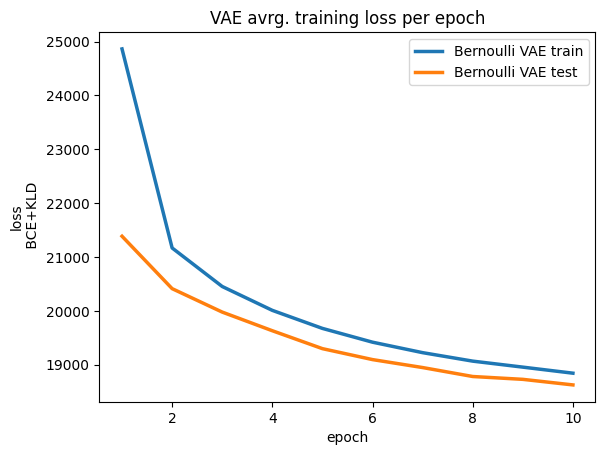

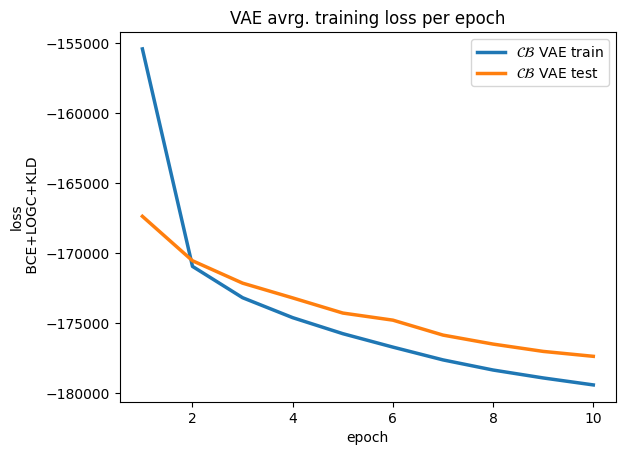

In [8]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vae], lw=2.5, label="Bernoulli VAE train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vae], lw=2.5, label="Bernoulli VAE test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_cbvae], lw=2.5, label="$\mathcal{CB}$ VAE train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_cbvae], lw=2.5, label="$\mathcal{CB}$ VAE test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+LOGC+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [9]:
# encode entries
latent_coordinates_vae = []
latent_coordinates_cbvae = []
for data in train_data:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates_vae.append(model_vae.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
    latent_coordinates_cbvae.append(model_cbvae.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
latent_coordinates_vae = np.array(latent_coordinates_vae)
latent_coordinates_cbvae = np.array(latent_coordinates_cbvae)


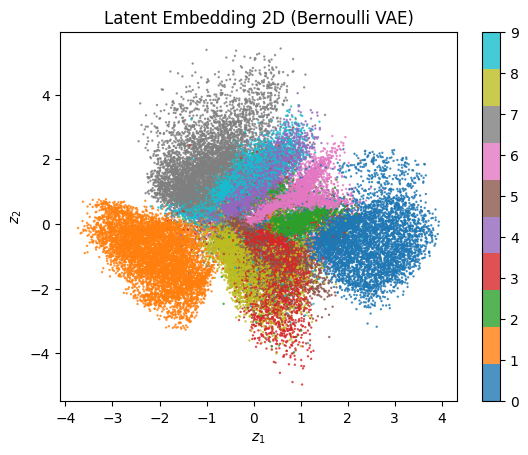

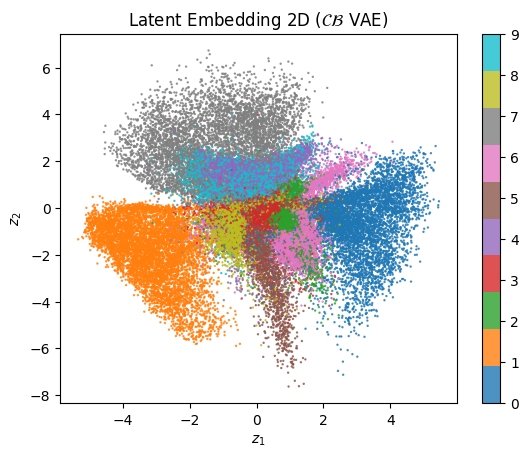

In [10]:
# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates_vae[:,0], latent_coordinates_vae[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D (Bernoulli VAE)")
plt.show()

plt.scatter(latent_coordinates_cbvae[:,0], latent_coordinates_cbvae[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D ($\mathcal{CB}$ VAE)")
plt.show()

Compared to the PPCA we obtain better spatial separation. 
Numbers of the same label are grouped together in coherent clusters.


The architecture is modified by introducing another hidden layer in the encoder and decoder.

### Visualization by Gauss CDF

In [11]:
## 2.) visualize across Gaussian CDF
n_cols = 12
z_space = torch.linspace(0.0001, 0.9999, n_cols) # for 5x5 grid
std_gauss = torch.distributions.normal.Normal(0, 1)

xx, yy = torch.meshgrid(z_space, z_space)

zz_gauss_cdf_vals = torch.dstack([std_gauss.icdf(xx), std_gauss.icdf(yy)]).reshape(-1, 2)
zz_gauss_cdf_vals.shape

/Users/vic/Desktop/Computer Science/2/PML/Final Project/PMLFinalProject/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([144, 2])

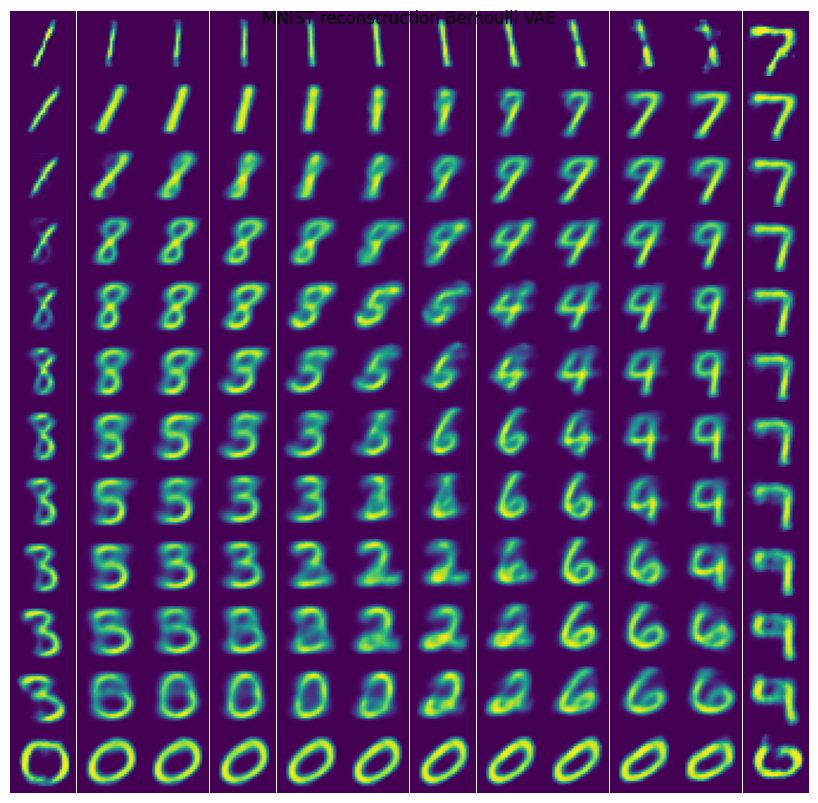

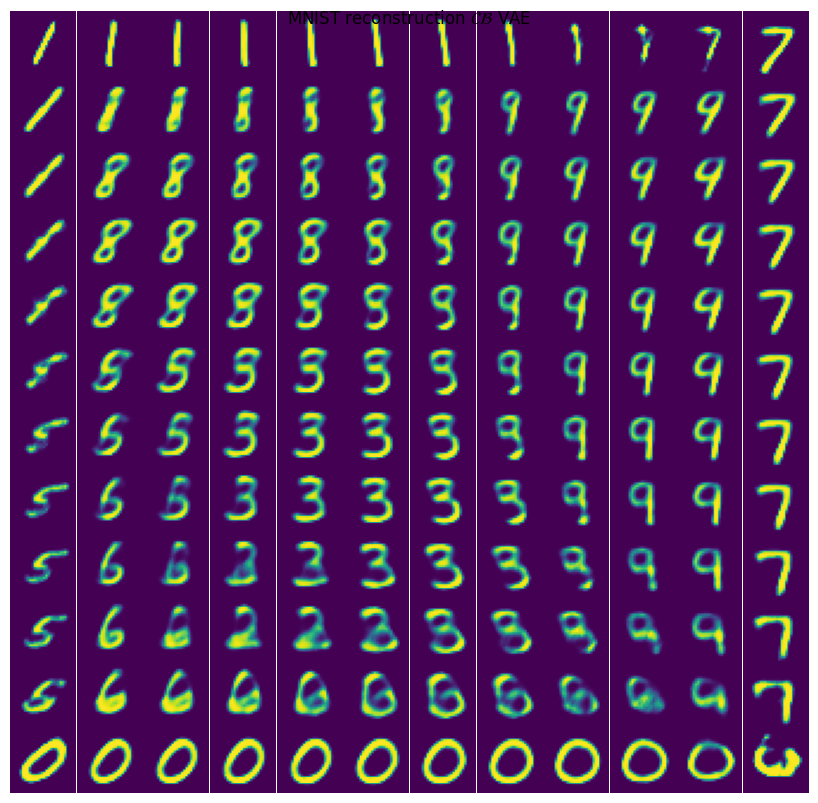

In [12]:

def plot_visualization(model, name):
    fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))

    k = 0
    for i in range(n_cols):
        for j in range(n_cols):
            _zz = zz_gauss_cdf_vals[k]
            reconstruction = model.decode(_zz.to(DEVICE)).cpu().detach().numpy()
            img = reconstruction.reshape((28,28))
            ax[i, j].imshow(img)
            ax[i, j].set_axis_off()
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            k += 1
    plt.suptitle(f"MNIST reconstruction {name}")
    plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
    plt.show()

plot_visualization(model_vae, "Bernoulli VAE")
plot_visualization(model_cbvae, "$\mathcal{CB}$ VAE")


### Monte-Carlo Estimation of likelihood

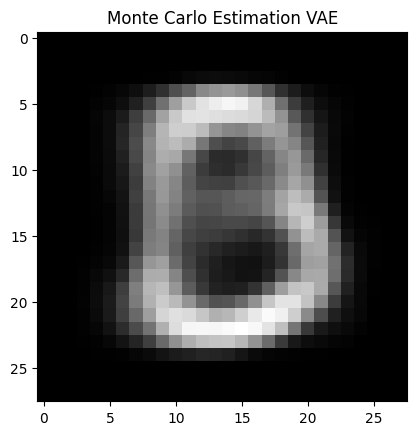

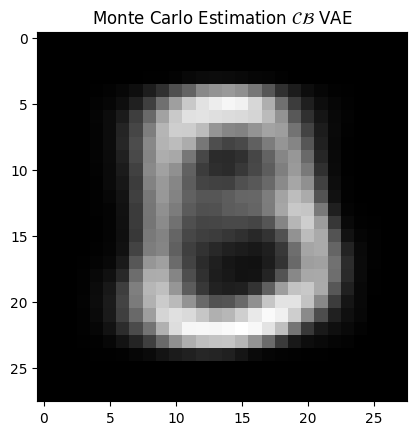

"\nimg_vae_is = vae_estimation_is.reshape((28, 28))\nplt.imshow(img_vae_is.detach().numpy(), cmap='gray')\nplt.title('Importance Sampling Estimation VAE')\nplt.show()\n\nimg_cbvae_is = cbvae_estimation_is.reshape((28, 28))\nplt.imshow(img_cbvae_is.detach().numpy(), cmap='gray')\nplt.title('Monte Carlo Estimation $\\mathcal{CB}$ VAE')\nplt.show()\n"

In [36]:
from torch.distributions import MultivariateNormal
from sklearn.mixture import GaussianMixture
'''
gmm_model = GaussianMixture(n_components=2, random_state=SEED)
gmm_model.fit(train_data)
'''

def importance_sampling(model: VAE, q: GaussianMixture, n_samples=1000, x_dim=784):
    estimation = torch.zeros(x_dim)
    for i in range(n_samples):
        x_i, _ = q.sample()
        x_i = torch.tensor(x_i.squeeze(), dtype=torch.float)
        mu, logvar = model.encode(x_i)
        covariance = torch.diag(torch.exp(logvar))
        z_i = model.reparameterize(mu, logvar)
        mn = MultivariateNormal(mu, covariance)
        p_z = torch.exp(mn.log_prob(z_i))
        q_z = torch.exp(torch.tensor(q.score_samples(x_i.reshape(1, -1))))
        recon_x = model.decode(z_i)
        estimation += p_z / q_z * recon_x

    return estimation / n_samples

def monte_carlo_estimation(model: VAE, n_samples=1000, x_dim=784):
    estimation = torch.zeros(x_dim)
    for i in range(n_samples):
        x_i = torch.rand(784)
        mu, logvar = model.encode(x_i)
        covariance = torch.diag(torch.exp(logvar))
        z_i = model.reparameterize(mu, logvar)
        mn = MultivariateNormal(mu, covariance)
        p_z = torch.exp(mn.log_prob(z_i))
        recon_x = model.decode(z_i)
        estimation += p_z * recon_x

    return estimation / n_samples

vae_estimation = monte_carlo_estimation(model_vae)
cbvae_estimation = monte_carlo_estimation(model_cbvae)
# vae_estimation_is = importance_sampling(model_vae, gmm_model)
# cbvae_estimation_is = importance_sampling(model_cbvae, gmm_model)

img_vae = vae_estimation.reshape((28,28))
plt.imshow(img_vae.detach().numpy(), cmap='gray')
plt.title('Monte Carlo Estimation VAE')
plt.show()

img_cbvae = cbvae_estimation.reshape((28, 28))
plt.imshow(img_vae.detach().numpy(), cmap='gray')
plt.title('Monte Carlo Estimation $\mathcal{CB}$ VAE')
plt.show()

'''
img_vae_is = vae_estimation_is.reshape((28, 28))
plt.imshow(img_vae_is.detach().numpy(), cmap='gray')
plt.title('Importance Sampling Estimation VAE')
plt.show()

img_cbvae_is = cbvae_estimation_is.reshape((28, 28))
plt.imshow(img_cbvae_is.detach().numpy(), cmap='gray')
plt.title('Monte Carlo Estimation $\mathcal{CB}$ VAE')
plt.show()
'''